![alt text](https://www.nlab.org.uk/wp-content/uploads/nlab.png)
# ML Practical: Unbalanced classes

Task: We'll again be predicting wine quality and using the modified dataset located:
`https://drive.google.com/uc?export=download&id=1opN2qPyUM2XSSn9KVkwwjfdLaWXeVBTt`

Recall we aim to predict the quality of wine (1-10) from a set of measured factors (based on physicochemical tests from samples from a glass) which include:
```
fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
```
The dataset still contains the same missing values. You will need to deal with these in a simlar way to last practical. **You should finish the previous practical before starting this one.** This goes for most practicals in this module.

Today we'll be addressing a slightly different problem: **Predicting if a wine is of high quality**. We will define high quality as a rating of >=7. Given most wine is not high quality, this means we have an unbalanced dataset.

The practical will take you, step-by-step through dealing with an unbalanced set in three ways:
1. Varying the probability threshold
2. Using weights in the classifier
3. Resampling using SMOTE

Ok. Let's start....


## Step 1
Let's load the data as a pandas dataframe

As always let's call either .head() or .describe() or both to check our load worked like we expected.

In [1]:
import pandas as pd
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1opN2qPyUM2XSSn9KVkwwjfdLaWXeVBTt')

## Step 2
We're going to do a standard prediction task so we need to split our data into input features and the output feature. **Let's call them X and y as is convention.**

At this point we need to convert y, our output feature, into a binary output feature replace quality ratings >=7 with **True** and everything else with **False**.

In [2]:
X = df.drop(columns = ['quality'])
y = df.quality >= 7

## Step 3
Now since we know we are going to do a classification task we should think about evaluation.

Since we've not got to the advanced evaluation lectures and to focus on the content of this practical (unbalanced classes) we are going to do the simpliest possible form of evaluation, a single test train split. **Remember: in the real world (and any coureworks) this is not acceptable.** But for now, that's what we're going to do.

So go ahead. Make a single test train split.

**NOTE 1:** Since we have an unbalanced target class we need to be careful that we don't accidentally randomly sample such that we have no high quality wine in our test set. That would make our task way to easy! Therefore we are going to tell the `train_test_split(..)` function to sample in a stratified way based on the class labels.

**NOTE 2:** So you can follow along with the solution later I'd recommend a `test_size of 0.33` and a `random_state of 42`. I'd also use the standard names for the output, i.e. `X_train, X_test, y_train, y_test`.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42, stratify = y)

## Step 4
Ok, so now to use your skills from last week. Fit a RandomForestClassifer.

So we are consistent (and to prevent some other issues associated with the fact we won't evaluate things 100% correctly in this practical for simplicity)

**MAKE SURE YOU USE THE FOLLOWING PARAMETERS FOR YOUR RandomForestClassifier**:

`RandomForestClassifier(max_depth = 10, random_state=42)`

Use the parameters throughout this practical.

**HINT 1:** I'd suggest using a pipeline.

**HINT 2:** Remember what a RandomForestClassifier can handle and what it can't.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

In [5]:
ki =  KNNImputer(n_neighbors = 3)
rf = RandomForestClassifier(max_depth = 10, random_state=42)
m = Pipeline(steps = [('imputer',ki), ('predictor',rf)])

In [6]:
m.fit(X_train, y_train)

,steps,"[('imputer', ...), ('predictor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,n_neighbors,3
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


## Step 5
Let's make some predictions! And test them of course. Of interest might be:
1. The accuacy
2. The recall (accuracy on class "high quality wine")
3. The specificity (accuracy on the class "other quality wine")
4. The balanced accuarcy.

So let's compute them all...

In [7]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score

balanced =  balanced_accuracy_score(y_test, m.predict(X_test))
acc =  accuracy_score(y_test, m.predict(X_test))
recal = recall_score(y_test, m.predict(X_test))
specificity = recall_score(y_test, m.predict(X_test), pos_label=0)

print(f'balanced: {balanced:.4f}, acc: {acc:.4f}, recall: {recal:.4f}, spec: {specificity:.4f}')

balanced: 0.6608, acc: 0.8788, recall: 0.3611, spec: 0.9605


Is this good enough? I don't think ~35% accuacy in predicting high quality wine is enough. So I'm going to say no. And since this is a practical you have to say no too and keep going at this point... No deciding "yes" just to go home early....

## Step 6: Dealing with unbalanced classes via probability thresholds
OK, finally we get to do some new stuff. Let's try and deal with this unbalanced class issue.

The first approach we are going to take is to look at the ROC curve and see if by changing the probability threshold we can get an acceptable trade-off between accuracies of each class.

To do this we are going to use a function from `sklearn.metrics` called `roc_curve(...)`. Google and find the documentation.

This function takes as parameters:
1. A set of prediction ground-truths (y_test)
2. A set of predictions **as probabilities**. We get these in a two step process. STEP 1: by calling the function `.predict_proba(X_test)` rather than `.predict(X_test)` on our classifier. This returns a matrix with two columns. Column 0 contains the probabiliy that the outcome is 0 (False) and column 1 containst the probabiliy that the outcome is 1 (True). The prediction probabilities that `roc_curve(...)` needs is the **second column ONLY**, the predicted probability that the data point is 1 (True).

It then computes the `recall` and `fallout (1-specificity)` scores assuming that the classifier uses differnt probability thresholds. I.e. in the first instance it will only predict 1 (True) if it is 110% sure (or some similar value such that it never predicts True) and using this definition will compute `recall` and `fallout`, with a recall of 0% and a fallout of 0%. This is then systematically relaxed (it'll predict true if it is 90% sure, then 80%, then 70%, ...., then 0%). In the final case `recall` is 100% and `fallout` is 100%.

**The result (output) of this function is three lists:**
`fallout, recall, thresholds` (in that order).

The first element in fallout is the fallout for the threshold recorded in the first element in the thresholds list. The first element in recall is the corresponding recall score. All elements in the lists are linked in this way.

**Your task:**
1. Predict the class probabilities for the test set
2. Extract the probabilities for the True class
3. Using the function `roc_curve(..)` compute these three lists.
4. Print a table with the thresholds as the first row, recall as the second, fallout (or if you find it easier to interpret specificity) as the third and balanced accuracy as the fourth. The simpliest way to do this is to create a pandas DataFrame and print this. By default, if there are many columns, pandas won't print them all. We do want it to though and we can force it to by setting this options first: `pd.options.display.max_columns = None`
5. Plot an ROC curve with this data. I.e. a plot of recall (y-axis) vs. fallout (x-axis) using matplotlib.



In [8]:
import numpy as np
from sklearn.metrics import roc_curve

probs = m.predict_proba(X_test)

probs_true = probs[:, 1]
fallout, recall, thresholds = roc_curve(y_test, probs_true)


In [9]:
specificity = 1 - fallout
balanced_acc = (recall + specificity) / 2

In [10]:
pd.options.display.max_columns = None

roc_table = pd.DataFrame({
    "threshold": thresholds,
    "recall": recall,
    "fallout": fallout,
    "specificity": specificity,
    "balanced_accuracy": balanced_acc
})

print(roc_table)

     threshold    recall   fallout  specificity  balanced_accuracy
0          inf  0.000000  0.000000     1.000000           0.500000
1     0.963511  0.013889  0.000000     1.000000           0.506944
2     0.692949  0.208333  0.000000     1.000000           0.604167
3     0.688987  0.208333  0.002193     0.997807           0.603070
4     0.685707  0.222222  0.002193     0.997807           0.610015
..         ...       ...       ...          ...                ...
124   0.000227  1.000000  0.923246     0.076754           0.538377
125   0.000116  1.000000  0.932018     0.067982           0.533991
126   0.000070  1.000000  0.945175     0.054825           0.527412
127   0.000047  1.000000  0.947368     0.052632           0.526316
128   0.000023  1.000000  1.000000     0.000000           0.500000

[129 rows x 5 columns]


**Sanity check to make sure it's all worked:** Check if, when a 50% threshold was used within the `roc_curve(..)` function you got the same `recall` and `fallout` scores are you previously computed.

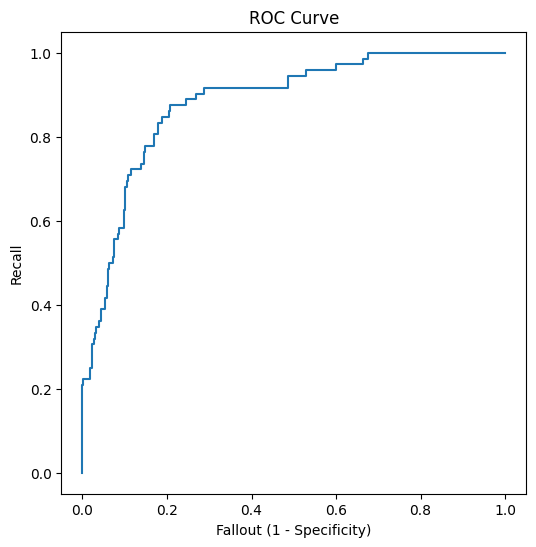

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(fallout, recall)
plt.xlabel("Fallout (1 - Specificity)")
plt.ylabel("Recall")
plt.title("ROC Curve")
plt.show()


In [ ]:
threshold_50_idx = np.argmin(np.abs(thresholds - 0.5))

print("Recall at 0.5:", recall[threshold_50_idx])
print("Fallout at 0.5:", fallout[threshold_50_idx])


Recall at 0.5: 0.3611111111111111
Fallout at 0.5: 0.039473684210526314


In [13]:
recall_score(y_test, m.predict(X_test))
recall_score(y_test, m.predict(X_test), pos_label=0)

0.9605263157894737

**Consider your graph and table.** Which theshold would you pick? Why? If we were to use this threshold would the classifier be more suitable for our task than before (i.e. when we were simply using a 50% threshold)?

**A final note before moving on**: we risk overfitting here as we are changing our model with knowledge of the test set (the large gain in results should make us wary). This is known as procedural overfitting and we'll be talking about this and how to avoid it next week while still being able to change these parameters. In effect we can see this parameter as a meta paramter of the model like the depth of the tree (which we could also vary systematically to find the best one - again possibly overfitting).

## Step 7a: Dealing with unbalanced class by reweighting samples when learning a classifier

OK. So that was one approach to creating a classifier that performs better on unbalanced data. The second approach we're going to try is instance re-weighting. This is perhaps one of the simpliest to implement **as we just pass a list of weights, one corresponding to each of the training points to the fit function**. Most sklearn models have this as an optional parameter.

Today we're using a RandomForestClassifier, so take a look at the documentation (google search for it) so you know what keyword it is.

Before we call the `.fit(..)` method of our RandomForestClassifier passing the weights we need to create them.

Recall from the lecture that we want to reweight the instances so that the two classes have the same weight (i.e. if we were to sum the weights over all instances of one class and sum the weights of all instances of the other class the sums would be equal). There are two ways of doing this:
1. Increasing the weight on instances of the minority class
2. Descreasing the weight on instances of the majority class

Let's choose option 1. In this case all majority class instances will get a weight of 1.
```
Let a = the number of majority class instances in our training set
Let b = the number of minority class instances in our training set

Minority class instances then get a weight of: a/b

Example:
If we have as a majority class four instances: ‡ ‡ ‡ ‡
        and a minority class of two instances: ø ø

Then we need to weight the ø by two as there is twice as many ø than ‡ (4/2).
```
So what are the steps here?
1. Compute the weight value
2. Create a list which, when y_train is 1 the weight is the weight value created (why? as this "slot" in the list corresponds to the row in the training dataset by row order) and when the y_train weight is 0 the weight is 1.
3. Now go ahead a train your classifier using weights.

**HINT:**: I'd first create a numpy array of all zeros (via `np.zeros(..)`) the same length as y_train. I'd then set all elements in the new array to be the weight which corresponds to `y_train == 1`. I'd then set the elements to 1 in the new array which correspond to `y_train == 0`.

In [21]:
a = sum(y_train == 0)  # majority
b = sum(y_train == 1)  # minority

weight_value = a / b

Now you've trained your classifier evaluate the accuracy, recall, specificity and balanced accuracy. How does it compare to the classifier trained without weights? Is it better? What about the old classifier after we choose a better probability threshold?

In [20]:
weights = np.ones(len(y_train))
weights[y_train == 1] = weight_value

In [19]:
m_weighted = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('predictor', RandomForestClassifier(max_depth=10, random_state=42))
])

m_weighted.fit(X_train, y_train, predictor__sample_weight=weights)

,steps,"[('imputer', ...), ('predictor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,n_neighbors,3
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


In [22]:
pred_w = m_weighted.predict(X_test)

balanced_w = balanced_accuracy_score(y_test, pred_w)
acc_w = accuracy_score(y_test, pred_w)
recall_w = recall_score(y_test, pred_w)
spec_w = recall_score(y_test, pred_w, pos_label=0)

print(f'balanced: {balanced_w:.4f}, acc: {acc_w:.4f}, recall: {recall_w:.4f}, spec: {spec_w:.4f}')

balanced: 0.6842, acc: 0.8788, recall: 0.4167, spec: 0.9518


OK, so hopefully that is a little better than the classifier before, before we (potentially overfit) by adjusting the threshold.

**Question:** Is learning using weights proccedural overfitting?

**Answer:** Not really. We've selected to re-weight due to the charateristics of the training set - indeed our weights are computed based on the training. In otherwords, we've got to this point without looking at our test set. If we then varied our weights, checking the performance on the test set this would be proccedural overfitting. Again - we'll talk about this more next week.

## Step 7b
Evaluate a range of thresholds using the `roc_curve(..)` function. As before print a table and plot a graph.

In [23]:
probs_w = m_weighted.predict_proba(X_test)[:,1]
fallout_w, recall_w, thresholds_w = roc_curve(y_test, probs_w)

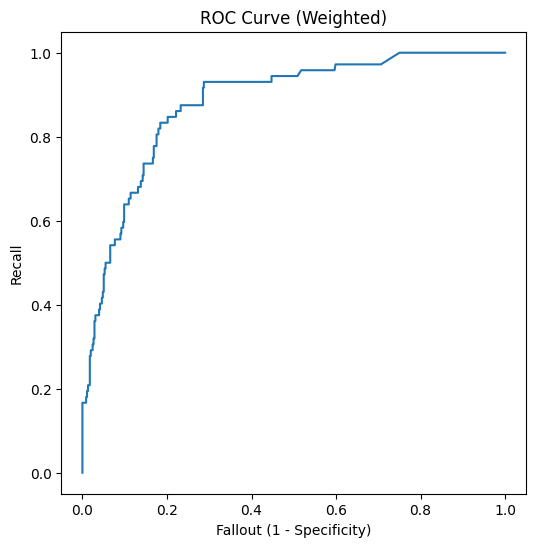

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(fallout_w, recall_w)
plt.xlabel("Fallout (1 - Specificity)")
plt.ylabel("Recall")
plt.title("ROC Curve (Weighted)")
plt.show()

**Question:** Considering the results, what threshold would you select? Would you use this model or one of the ones from before?

Would I select this model (I'm going to assume you picked well)? Maybe - the selected threshold is not as extreme and points to a lower likelihood of potential overfitting. Of course, in practice, I don't really have enough information at the moment to choose as we have not guarded against procedural overfitting! So for a definitive answer we'll have to wait until next week.

**For now the take home message is:**
1. Re-weighting does help
2. Thresholding can help (although how much we can't tell yet as we don't know how much, if any, is being caused by overfitting)
3. That we can do 1 and 2 together if we want (but again until next week's lecture we can't tell how much this will truely help when predicting new data as we don't know how much, if any, is being caused by overfitting)

## Step 8: Dealing with unbalanced class using SMOTE
Now let do SMOTE and see how that compares.

We will use the `imblaern` package. Specifically we will use the implemenation found here:

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

To use this package we will `.fit(..)` a SMOTE object using the training set and then call a function called `resample(..)` to generate a new training set.

### Step 8a: Import SMOTE

The import we will need is:
`from imblearn.over_sampling import SMOTE`

### Step 8b: Check the number of each class in your training labels (so we can check later SMOTE worked.

You can use this code (assuming your training set labels are in a variable called `y_train`:
```
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
```

### Step 8c: Create the SMOTE object.
Have a quick look at the documentation to see what parameters exist. In this case, however, the defaults are fine. The **one thing we will set is the random_state = 42** so we all get the same answers and so things do not change due to randomness as we adjust and evaluate the effect of changes to other parts of the algorithm / machine learning pipeline.


### Step 8d: Create the new (balanced) training set using SMOTE
Unfortunately SMOTE does not handle missing values. Given what you were taught in the lecture can you think of why?

As such we need to impute our data first. We could use a pipeline, but for simplicilty let's just fit a stand-alone KNNImputer and fit it using the training data and then transform the training data to return us a training set with the missing values filled in.

Use a KNNImputer to create a new set of input features for training (**let's call it `X_trainI`**).

Now we have a dataset (`X_trainI`, `y_train`) without missing values we can fit the SMOTE object and call resample. We can do this as two steps or a single step using the function `.fit_sample(..)`. Given `.fit()` doesn't really do anything (it is included mainly to follow the sklearn interface) we should **always use `.fit_sample(..)`.

If you read the documents you will find that: `.fit_sample(...)` takes the input features and the output labels for the set we want to resample and returns two things - a `new input feature matrix` and a `new output label list`.

In otherwords the way we call is it is (assuming your SMOTE object you created is called `sm`):

`X_res, y_res = sm.fit_resample(X_trainI, y_train)`

Ok, now create the resampled training set! Ensure you are passing the right variable given you may have different variable names. After use the code I gave you before (the one using `Counter`) to check if the training data set is now balanced or not - i.e to see what SMOTE has done.

### Step 8e: Train and evaluate our classifier using our new SMOTE training dataset.

Go ahead. You should know what to do by now. If not, ask!

You should compute:
1. The accuracy, recall, specificity, balanced accuracy for the classifier without considering changing the probability thesholds
2. Vary the probability threshold and print the table as before as well as the ROC graph.

Did this help?

# Optional Extras
1. Read this [documentation](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline) and include SMOTE in a pipeline. HINT: A key statement is "The samplers are only applied during fit".
2. If we use the reweighting method we can trade-off accuacy between classes (recall and specificity in the binary case) by varying our weights as an alternative to varying the probability thresholds. Doing this systematically we can generate a plot similar to the ROC plots. Do this and compare your results. Did you get better results than looking at the probability thresholds (just for the reweighting case)?
3. Follow up you best case with an analytis of the probability thresholds. How does your results compare to all other results?
4. Read more on how SMOTE actually works [here](http://rikunert.com/SMOTE_explained)
